## Library

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
import random
from collections import deque, namedtuple
import gymnasium as gym
import gym_anytrading
from gym_anytrading.envs import StocksEnv
import yfinance as yf
import datetime
import pandas_datareader as pdr
import pandas as pd
from matplotlib import pyplot as plt
import json
from itertools import product

## QNetwork

The QNetwork is fully connected, maybe it could be change so that it is not fully connected. But this is much more complicated.

In [2]:
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, lr, hidden_dims=[64]):
        super(QNetwork, self).__init__()
        self.layers = nn.ModuleList()  # Initialize a ModuleList to hold the layers

        # First layer
        self.layers.append(nn.Linear(state_dim, hidden_dims[0]))
        
        # Hidden layers
        for i in range(1, len(hidden_dims)):
            self.layers.append(nn.Linear(hidden_dims[i-1], hidden_dims[i]))

        # Output layer
        self.layers.append(nn.Linear(hidden_dims[-1], action_dim))

        # Custom weight initialization
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                # Using He initialization for weights
                init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
                # Initializing biases to zero
                init.constant_(layer.bias, 0)
        
        self.lr = lr
        self.optimizer = optim.Adam(self.parameters(), lr=self.lr)

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = torch.relu(layer(x))
        x = self.layers[-1](x)
        return x

In [3]:
class DuelingQNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, lr, hidden_dims=[64]):
        super(DuelingQNetwork, self).__init__()
        self.feature = nn.Sequential(
            nn.Linear(state_dim, hidden_dims[0]),
            nn.ReLU()
        )
        # Continue adding hidden layers if needed
        for i in range(1, len(hidden_dims)):
            self.feature.add_module('hidden_layer_%d' % i,
                                    nn.Sequential(
                                        nn.Linear(hidden_dims[i-1], hidden_dims[i]),
                                        nn.ReLU()
                                    ))
        
        # Value stream
        self.value_stream = nn.Sequential(
            nn.Linear(hidden_dims[-1], 1)  # Outputs a single value
        )
        
        # Advantage stream
        self.advantage_stream = nn.Sequential(
            nn.Linear(hidden_dims[-1], action_dim)
        )
        
        self.lr = lr
        self.optimizer = optim.Adam(self.parameters(), lr=self.lr)

    def forward(self, x):
        features = self.feature(x)
        values = self.value_stream(features)
        advantages = self.advantage_stream(features)
        
        # Combine the value and advantages to get the final Q-values
        q_values = values + (advantages - advantages.mean(dim=1, keepdim=True))
        return q_values

## Memory

In [4]:
class ReplayMemory:
    def __init__(self, capacity):
        """Initialize the memory buffer."""
        self.capacity = capacity
        self.memory = deque([], maxlen=capacity) 

    def append(self, transition):
        """Add a transition to the memory buffer."""
        self.memory.append(transition)

    def sample(self, sample_size):
        """Sample a batch of transitions from the memory buffer.
        
        Ensures sample size is not larger than the current memory size.
        """
        sample_size = min(sample_size, len(self.memory))
        return random.sample(self.memory, sample_size)

    def __len__(self):
        """Return the current size of the memory buffer."""
        return len(self.memory)

# Agents

In [5]:
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

## DQN

In [6]:
class DQN:
    def __init__(self, state_dim, action_dim, lr, hidden_dims=[64], memory_size=10000, batch_size=32, gamma=0.99, epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.memory = ReplayMemory(memory_size)
        self.batch_size = batch_size
        self.gamma = gamma 
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.policy_net = QNetwork(state_dim, action_dim, lr, hidden_dims)  # Q-network
        self.target_net = QNetwork(state_dim, action_dim, lr, hidden_dims)  # Target network
        self.target_net.load_state_dict(self.policy_net.state_dict())  # Initialize target network weights
        self.target_net.eval()  # Set target net to evaluation mode

    def select_action(self, state):
        """
        Selects an action based on the current state using an epsilon-greedy policy.
        """
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.action_dim)  # Random action
        else:
            flat_state = state.flatten()
            flat_state = torch.FloatTensor(flat_state).unsqueeze(0)  # Convert to tensor and add batch dimension
            with torch.no_grad():
                q_values = self.policy_net(flat_state)
            return q_values.max(1)[1].item()  # Action with the highest Q-value

    def optimize_model(self):
        """
        Performs a single step of optimization for the policy network.
        """

        transitions = self.memory.sample(self.batch_size)
        
        
        batch = Transition(*zip(*transitions))  # Convert to Transition of batch-arrays

        
        
        # Extract tensors for states, actions, etc. from the batch
        state_batch = torch.FloatTensor([s.reshape(-1) for s in batch.state])
        action_batch = torch.LongTensor(batch.action).unsqueeze(1)
        reward_batch = torch.FloatTensor(batch.reward)
        next_state_batch = torch.FloatTensor([s.reshape(-1) for s in batch.next_state])
        done_batch = torch.FloatTensor(batch.done)


        # Compute Q(s_t, a) - the Q values for the current state
        current_q_values = self.policy_net(state_batch).gather(1, action_batch)

        # Compute V(s_{t+1}) for all next states, using the target network
        next_state_values = self.target_net(next_state_batch).max(1)[0].detach()
        # Compute the expected Q values
        expected_q_values = reward_batch + (self.gamma * next_state_values * (1 - done_batch))

        # Compute Huber loss
        loss = F.smooth_l1_loss(current_q_values, expected_q_values.unsqueeze(1))

        # Optimize the model
        self.policy_net.optimizer.zero_grad()
        loss.backward()
        for param in self.policy_net.parameters():
            param.grad.data.clamp_(-1, 1)
        self.policy_net.optimizer.step()

    def update_target_network(self):
        """
        Update weights of the target network to match those of the policy network.
        """
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def decay_epsilon(self):
        """
        Decays epsilon according to the decay rate, down to a minimum value.
        """
        self.epsilon = max(self.epsilon_end, self.epsilon_decay * self.epsilon)

## DDQN

In [7]:
class DDQN:
    def __init__(self, state_dim, action_dim, lr, hidden_dims=[64], memory_size=10000, batch_size=32, gamma=0.99, epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.memory = ReplayMemory(memory_size)
        self.batch_size = batch_size
        self.gamma = gamma 
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.policy_net = QNetwork(state_dim, action_dim, lr, hidden_dims)
        self.target_net = QNetwork(state_dim, action_dim, lr, hidden_dims)  
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()  

    def select_action(self, state):
        """
        Selects an action based on the current state using an epsilon-greedy policy.
        """
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.action_dim)  # Random action
        else:
            flat_state = state.flatten()
            flat_state = torch.FloatTensor(flat_state).unsqueeze(0)  # Convert to tensor and add batch dimension
            with torch.no_grad():
                q_values = self.policy_net(flat_state)
            return q_values.max(1)[1].item()  # Action with the highest Q-value
        
    def optimize_model(self):
        if len(self.memory) < self.batch_size:
            return  # Not enough samples to perform optimization

        transitions = self.memory.sample(self.batch_size)
        batch = Transition(*zip(*transitions))
        np_state_batch = np.array([s.reshape(-1) for s in batch.state])
        np_next_state_batch = np.array([s.reshape(-1) for s in batch.next_state])
        
        state_batch = torch.FloatTensor(np_state_batch)
        action_batch = torch.LongTensor(batch.action).unsqueeze(1)
        reward_batch = torch.FloatTensor(batch.reward)
        next_state_batch = torch.FloatTensor(np_next_state_batch)
        done_batch = torch.FloatTensor(batch.done)
        
        # Get the Q values for the current state
        current_q_values = self.policy_net(state_batch).gather(1, action_batch)
        
        # DDQN update rule
        # Select the best action for the next state using the policy net
        next_state_actions = self.policy_net(next_state_batch).max(1)[1].unsqueeze(1)
        # Evaluate the selected action with the target net
        next_state_values = self.target_net(next_state_batch).gather(1, next_state_actions).squeeze(1)
        
        # Compute the expected Q values
        expected_q_values = reward_batch + (self.gamma * next_state_values * (1 - done_batch))
        
        # Compute loss
        loss = F.smooth_l1_loss(current_q_values.squeeze(1), expected_q_values)
        
        # Optimize the model
        self.policy_net.optimizer.zero_grad()
        loss.backward()
        for param in self.policy_net.parameters():
            param.grad.data.clamp_(-1, 1)
        self.policy_net.optimizer.step()

    def update_target_network(self):
        """
        Update weights of the target network to match those of the policy network.
        """
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def decay_epsilon(self):
        """
        Decays epsilon according to the decay rate, down to a minimum value.
        """
        self.epsilon = max(self.epsilon_end, self.epsilon_decay * self.epsilon)

    

## Dueling DDQN

In [8]:
class DuelingDDQN(DDQN):
    def __init__(self, state_dim, action_dim, lr, hidden_dims=[64], memory_size=10000, batch_size=32, gamma=0.99, epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995):
        super().__init__(state_dim, action_dim, lr, hidden_dims, memory_size, batch_size, gamma, epsilon_start, epsilon_end, epsilon_decay)
        self.policy_net = DuelingQNetwork(state_dim, action_dim, lr, hidden_dims)
        self.target_net = DuelingQNetwork(state_dim, action_dim, lr, hidden_dims)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

# Data

In [9]:
def ticker_data(name, date):

    ticker_symbol = name
    start_date = date
    end_date = datetime.datetime.now().strftime('%Y-%m-%d')  # Today's date

    # Fetch the historical market data
    ticker_data = yf.Ticker(ticker_symbol)
    ticker_df = ticker_data.history(period="1d", start=start_date, end=end_date)

    # Calculate the daily variance (High - Low)^2 and add it as a new column
    ticker_df['Variance'] = (ticker_df['High'] - ticker_df['Low']) ** 2

    # Calculate the log of prices and add them as new columns
    ticker_df['Log Open'] = np.log(ticker_df['Open'])
    ticker_df['Log High'] = np.log(ticker_df['High'])
    ticker_df['Log Low'] = np.log(ticker_df['Low'])
    ticker_df['Log Close'] = np.log(ticker_df['Close'])

    # Calculate the log variance as the square of the difference between Log High and Log Low
    ticker_df['Log Variance'] = (ticker_df['Log High'] - ticker_df['Log Low']) ** 2

    # Calculate daily logarithmic returns
    ticker_df['Log Returns'] = np.log(ticker_df['Close'] / ticker_df['Close'].shift(1))

    # Calculate the 10-day and 30-day rolling standard deviation of the log returns
    ticker_df['10-day Volatility'] = ticker_df['Log Returns'].rolling(window=10).std() * np.sqrt(252)
    ticker_df['30-day Volatility'] = ticker_df['Log Returns'].rolling(window=30).std() * np.sqrt(252)

    # Calculate the n-day Price Rate of Change (ROC) for the closing prices
    ticker_df['3-day ROC'] = ((ticker_df['Close'] - ticker_df['Close'].shift(3)) / ticker_df['Close'].shift(3)) * 100
    ticker_df['5-day ROC'] = ((ticker_df['Close'] - ticker_df['Close'].shift(5)) / ticker_df['Close'].shift(5)) * 100
    ticker_df['10-day ROC'] = ((ticker_df['Close'] - ticker_df['Close'].shift(10)) / ticker_df['Close'].shift(10)) * 100
    ticker_df['30-day ROC'] = ((ticker_df['Close'] - ticker_df['Close'].shift(30)) / ticker_df['Close'].shift(30)) * 100

    # Calculate the 10-day, 50-day, 100-day and 200-day moving averages of the closing prices
    ticker_df['10-day MA'] = ticker_df['Close'].rolling(window=10).mean()
    ticker_df['50-day MA'] = ticker_df['Close'].rolling(window=50).mean()
    ticker_df['100-day MA'] = ticker_df['Close'].rolling(window=100).mean()
    ticker_df['200-day MA'] = ticker_df['Close'].rolling(window=200).mean()

    # change index format so that is only year-month-day
    ticker_df.index = ticker_df.index.date

    # Define the date range
    start_date = datetime.datetime(1995, 1, 1)
    end_date = datetime.datetime.now()

    # Interest Rates example (Federal Funds Effective Rate)
    interest_rates = pdr.get_data_fred('FEDFUNDS', start_date, end_date)

    # Inflation Rates example (Consumer Price Index for All Urban Consumers: All Items in U.S. City Average)
    inflation_rates = pdr.get_data_fred('CPIAUCSL', start_date, end_date)

    # GDP Growth Rates example (Real Gross Domestic Product, 3 Decimal)
    gdp_growth = pdr.get_data_fred('A191RL1Q225SBEA', start_date, end_date)

    # Unemployment Rates
    unemployment_rates = pdr.get_data_fred('UNRATE', start_date, end_date)

    # Combine into a single DataFrame
    economic_data = pd.concat([interest_rates, inflation_rates, gdp_growth, unemployment_rates], axis=1)
    economic_data.columns = ['Interest Rates', 'Inflation Rates (CPI)', 'GDP Growth', 'Unemployment Rates']

    # Forward fill to replace NaN values with the previous non-NaN value in each column
    economic_data.ffill(inplace=True)

    # Backward fill to replace any remaining NaNs at the start of the DataFrame
    economic_data.bfill(inplace=True)

    ticker_df.index = pd.to_datetime(ticker_df.index)
    economic_data.index = pd.to_datetime(economic_data.index)

    ticker_df['YearMonth'] = ticker_df.index.to_series().dt.to_period('M')
    economic_data['YearMonth'] = economic_data.index.to_series().dt.to_period('M')

    ticker_df = ticker_df.reset_index()

    all_df = pd.merge(ticker_df, economic_data, on='YearMonth')

    all_df.drop('YearMonth', axis=1, inplace=True)

    all_df.set_index('index', inplace=True)

    all_df.index.name = 'Date'

    all_df = all_df.dropna()

    return all_df


# Training

In [10]:
def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Close'].to_numpy()[start:end]
    signal_features = env.df.loc[:, env.df.columns != 'Close'].to_numpy()[start:end]
    return prices, signal_features
    
class MyCustomEnv(StocksEnv):
    _process_data = add_signals

In [11]:
def create_env(ticker, days_train, days_test):
    df = ticker_data(ticker, "2010-06-29")
    num_rows = len(df)
    ending_training = num_rows - days_test
    starting_training = ending_training - days_train
    return MyCustomEnv(df=df, window_size=10, frame_bound=(starting_training,ending_training))

In [36]:
def test_model(model, env, epsilon=0.01):
    state = env.reset()[0]
    total_reward = 0
    steps = 0

    while True:
        
        state_flattened = state.flatten()
        state_tensor = torch.FloatTensor(state_flattened).unsqueeze(0)
        with torch.no_grad():
            q_values = model.policy_net(state_tensor)
        
        if np.random.rand() > epsilon:
            action = q_values.max(1)[1].item()
        else:
            action = env.action_space.sample()
        next_state, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        state = next_state
        steps += 1
        done = terminated or truncated
        if done:
            print(f"Total reward: {total_reward}, Steps: {steps}, Info: {info}")
            break

## Training DQN

### AAPL

In [54]:
env = create_env('AAPL', 365, 90)

state_dim = env.observation_space.shape[0] * env.observation_space.shape[1]
action_dim = env.action_space.n  
learning_rate = 0.005
hidden_dims = [64, 64]  
memory_size = 10000
batch_size = 8
gamma = 0.9  
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 0.9

dqn_agent = DQN(state_dim, action_dim, learning_rate, hidden_dims=hidden_dims,
                memory_size=memory_size, batch_size=batch_size, gamma=gamma,
                epsilon_start=epsilon_start, epsilon_end=epsilon_end, epsilon_decay=epsilon_decay)

TARGET_UPDATE = 10
num_episodes = 1000

for episode in range(num_episodes):
    state = env.reset()[0]
    steps = 0
    
    while True:
        action = dqn_agent.select_action(state)  # Use DQN agent to select action
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        # Store the transition in memory
        dqn_agent.memory.append((state, action, reward, next_state, done))

        # Move to the next state
        state = next_state

        # Perform one step of the optimization
        dqn_agent.optimize_model()

        steps += 1

        if done:
            #print(f"Episode: {episode + 1}, Info: {info}")
            break
        
    # Update the target network, copying all weights and biases in DQN
    if episode % TARGET_UPDATE == 0:
        dqn_agent.update_target_network()

    dqn_agent.decay_epsilon()

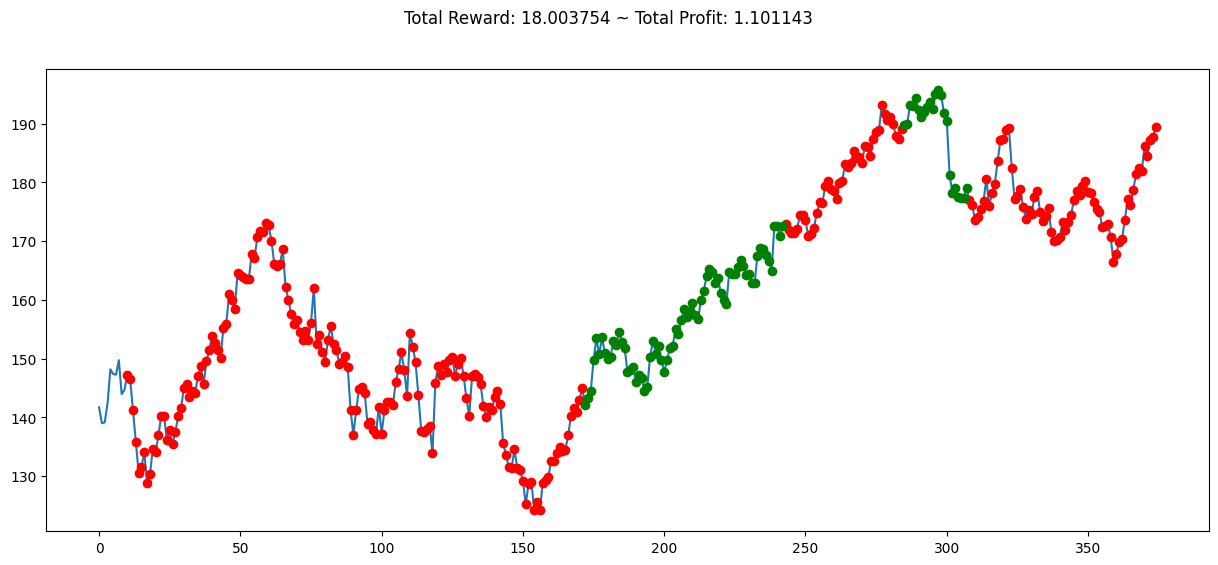

In [55]:
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

In [56]:
test_env = create_env('AAPL', 90, 0)
test_model(dqn_agent, test_env, epsilon=0.01)


Total reward: 4.1878509521484375, Steps: 89, Info: {'total_reward': 4.1878509521484375, 'total_profit': 0.9636189482224996, 'position': <Positions.Long: 1>}


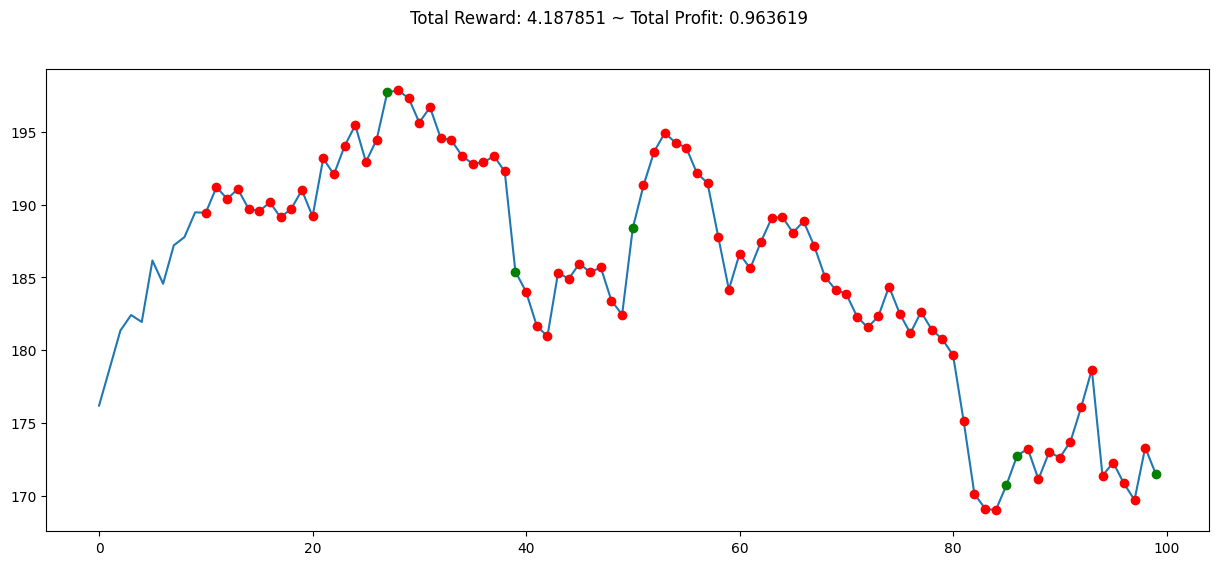

In [57]:
plt.figure(figsize=(15,6))
plt.cla()
test_env.render_all()
plt.show()

### AMZN

In [66]:
env_amzn_dqn = create_env('AMZN', 365, 90)

state_dim = env.observation_space.shape[0] * env.observation_space.shape[1]
action_dim = env.action_space.n  
learning_rate = 0.01
hidden_dims = [64, 64]  # Example: two hidden layers with 64 nodes each
memory_size = 10000
batch_size = 64
gamma = 0.9  # Discount factor for future rewards
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 0.9

dqn_agent_amzn = DQN(state_dim, action_dim, learning_rate, hidden_dims=hidden_dims,
                memory_size=memory_size, batch_size=batch_size, gamma=gamma,
                epsilon_start=epsilon_start, epsilon_end=epsilon_end, epsilon_decay=epsilon_decay)

TARGET_UPDATE = 10
num_episodes = 1000

for episode in range(num_episodes):
    state = env_amzn_dqn.reset()[0]
    steps = 0
    
    while True:
        action = dqn_agent_amzn.select_action(state)  # Use DQN agent to select action
        next_state, reward, terminated, truncated, info = env_amzn_dqn.step(action)
        done = terminated or truncated

        # Store the transition in memory
        dqn_agent_amzn.memory.append((state, action, reward, next_state, done))

        # Move to the next state
        state = next_state

        # Perform one step of the optimization
        dqn_agent_amzn.optimize_model()

        steps += 1

        if done:
            #print(f"Episode: {episode + 1}, Info: {info}")
            break
        
    # Update the target network, copying all weights and biases in DQN
    if episode % TARGET_UPDATE == 0:
        dqn_agent_amzn.update_target_network()

    
    dqn_agent_amzn.decay_epsilon()

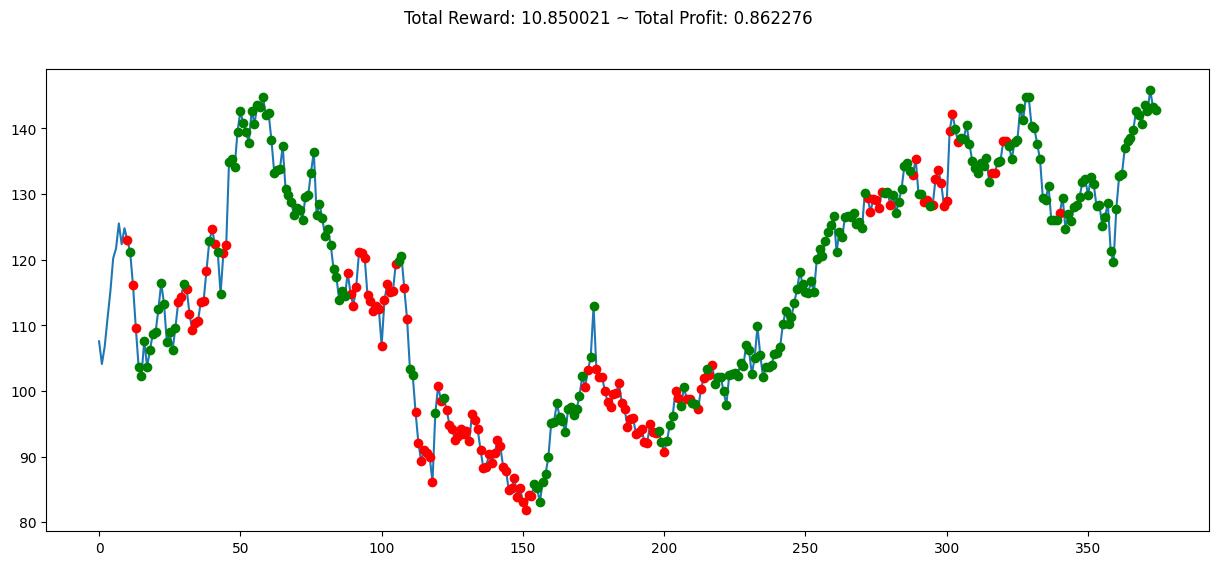

In [67]:
plt.figure(figsize=(15,6))
plt.cla()
env_amzn_dqn.render_all()
plt.show()

In [68]:
test_env_amzn_dqn = create_env('AMZN', 90, 0)
test_model(dqn_agent_amzn, test_env_amzn_dqn, epsilon=0.01)

Total reward: 0, Steps: 89, Info: {'total_reward': 0.0, 'total_profit': 1.215926352375789, 'position': <Positions.Long: 1>}


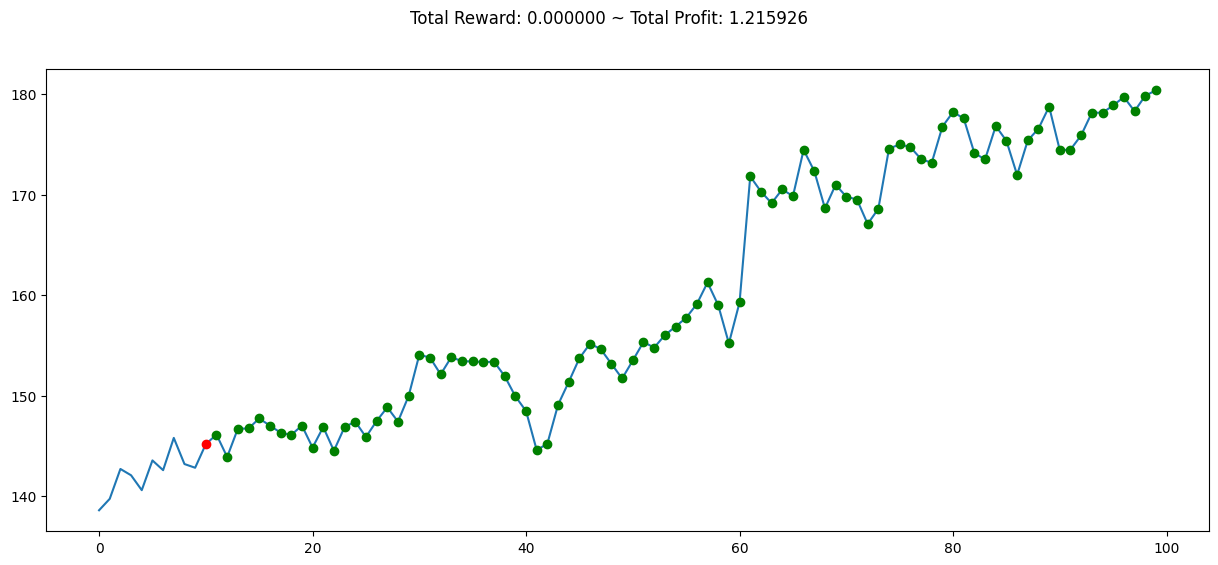

In [69]:
plt.figure(figsize=(15,6))
plt.cla()
test_env_amzn_dqn.render_all()
plt.show()

### TSLA

In [70]:
env_tsla_dqn = create_env('TSLA', 365, 90)

state_dim = env_tsla_dqn.observation_space.shape[0] * env_tsla_dqn.observation_space.shape[1]
action_dim = env_tsla_dqn.action_space.n  
learning_rate = 0.01
hidden_dims = [64, 64]  # Example: two hidden layers with 64 nodes each
memory_size = 10000
batch_size = 8
gamma = 0.9  # Discount factor for future rewards
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 0.9

dqn_agent_tsla = DQN(state_dim, action_dim, learning_rate, hidden_dims=hidden_dims,
                memory_size=memory_size, batch_size=batch_size, gamma=gamma,
                epsilon_start=epsilon_start, epsilon_end=epsilon_end, epsilon_decay=epsilon_decay)

TARGET_UPDATE = 10
num_episodes = 1000

for episode in range(num_episodes):
    state = env_tsla_dqn.reset()[0]
    steps = 0
    
    while True:
        action = dqn_agent_tsla.select_action(state)  # Use DQN agent to select action
        next_state, reward, terminated, truncated, info = env_tsla_dqn.step(action)
        done = terminated or truncated

        # Store the transition in memory
        dqn_agent_tsla.memory.append((state, action, reward, next_state, done))

        # Move to the next state
        state = next_state

        # Perform one step of the optimization
        dqn_agent_tsla.optimize_model()

        steps += 1

        if done:
            #print(f"Episode: {episode + 1}, Info: {info}")
            break
        
    # Update the target network, copying all weights and biases in DQN
    if episode % TARGET_UPDATE == 0:
        dqn_agent_tsla.update_target_network()

    dqn_agent_tsla.decay_epsilon()

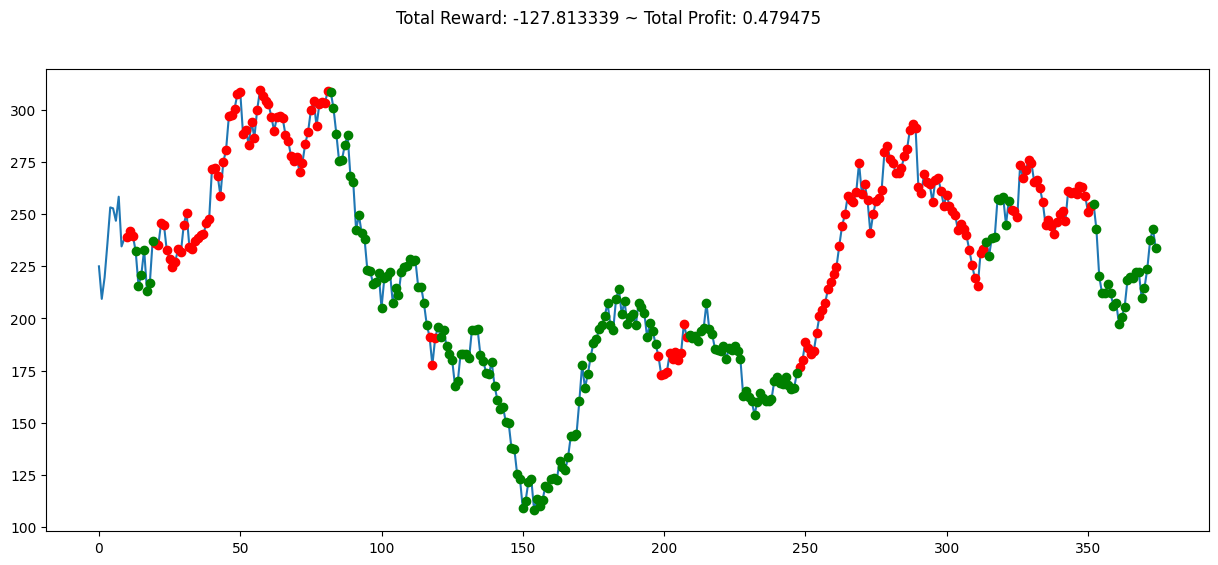

In [71]:
plt.figure(figsize=(15,6))
plt.cla()
env_tsla_dqn.render_all()
plt.show()

In [90]:
test_env_tsla_dqn = create_env('TSLA', 90, 0)
test_model(dqn_agent_tsla, test_env_tsla_dqn, epsilon=0.01)

Total reward: -4.6999969482421875, Steps: 89, Info: {'total_reward': -4.6999969482421875, 'total_profit': 0.9667636735611066, 'position': <Positions.Short: 0>}


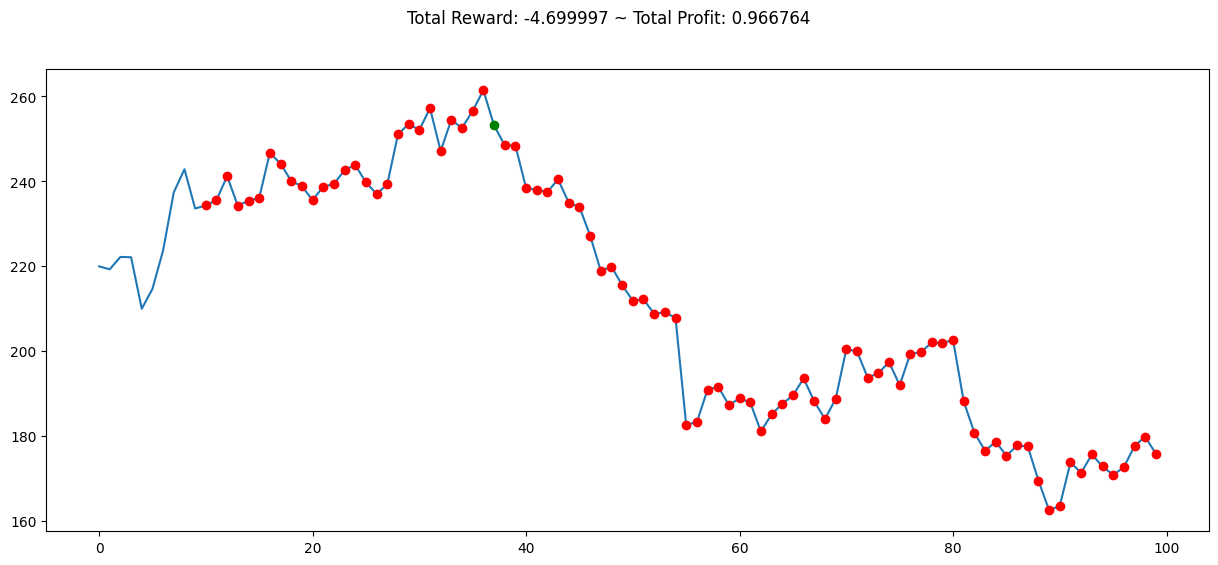

In [103]:
plt.figure(figsize=(15,6))
plt.cla()
test_env_tsla_dqn.render_all()
plt.show()

## DDQN Training

### AAPL

In [58]:
env = create_env('AAPL', 365, 90)

state_dim = env.observation_space.shape[0] * env.observation_space.shape[1]
action_dim = env.action_space.n  
learning_rate = 0.0075
hidden_dims = [64, 32]
memory_size = 10000
batch_size = 16
gamma = 0.6 
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 0.9

ddqn_agent = DDQN(state_dim, action_dim, learning_rate, hidden_dims=hidden_dims,
                memory_size=memory_size, batch_size=batch_size, gamma=gamma,
                epsilon_start=epsilon_start, epsilon_end=epsilon_end, epsilon_decay=epsilon_decay)

TARGET_UPDATE = 10
num_episodes = 1000

for episode in range(num_episodes):
    state = env.reset()[0]
    steps = 0
    
    while True:
        action = ddqn_agent.select_action(state)  # Use DQN agent to select action
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        # Store the transition in memory
        ddqn_agent.memory.append((state, action, reward, next_state, done))

        # Move to the next state
        state = next_state

        # Perform one step of the optimization
        ddqn_agent.optimize_model()

        steps += 1

        if done:
            #print(f"Episode: {episode + 1}, Info: {info}")
            break
        
    # Update the target network, copying all weights and biases in DQN
    if episode % TARGET_UPDATE == 0:
        ddqn_agent.update_target_network()

    # Decay epsilon
    ddqn_agent.decay_epsilon()

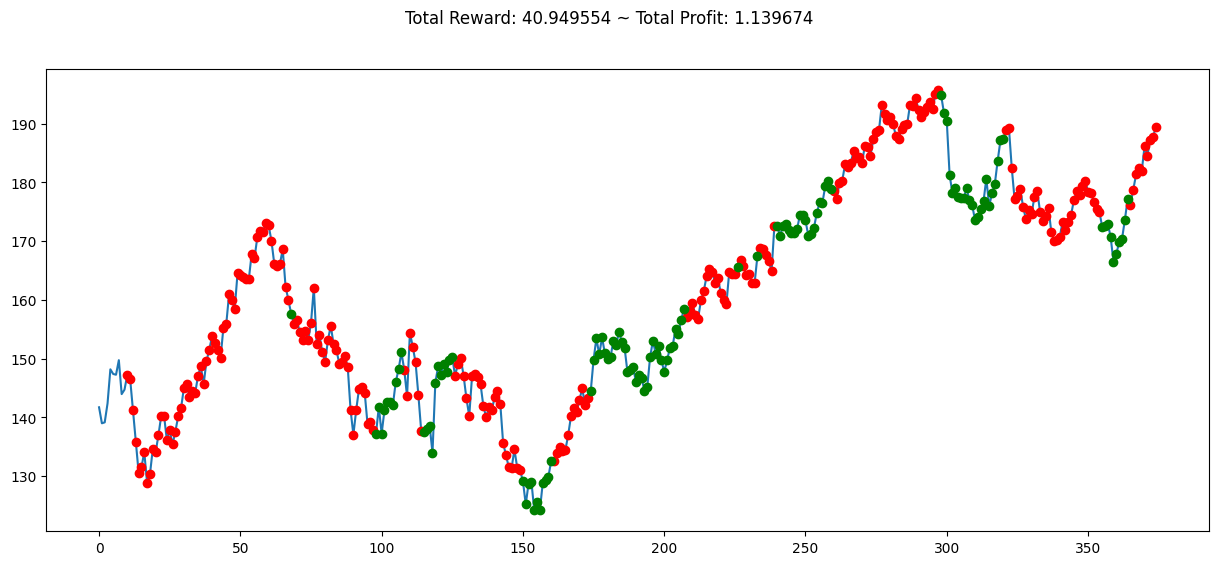

In [59]:
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

In [60]:
test_env = create_env('AAPL', 90, 0)
test_model(ddqn_agent, test_env, epsilon=0.01)

Total reward: -1.388214111328125, Steps: 89, Info: {'total_reward': -1.388214111328125, 'total_profit': 0.9776744059016684, 'position': <Positions.Short: 0>}


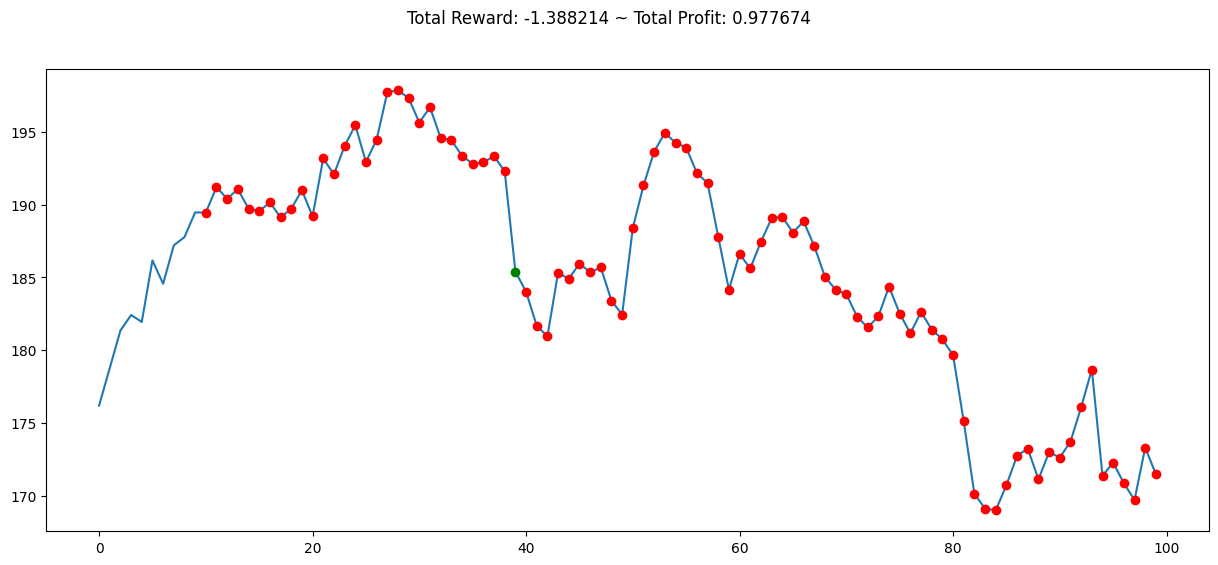

In [61]:
plt.figure(figsize=(15,6))
plt.cla()
test_env.render_all()
plt.show()

### AMZN

In [74]:
env_amzn_ddqn = create_env('AMZN', 365, 90)

state_dim = env.observation_space.shape[0] * env.observation_space.shape[1]
action_dim = env.action_space.n  
learning_rate = 0.01
hidden_dims = [64, 32]
memory_size = 10000
batch_size = 12
gamma = 0.6  
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 0.9

ddqn_agent_amzn = DDQN(state_dim, action_dim, learning_rate, hidden_dims=hidden_dims,
                memory_size=memory_size, batch_size=batch_size, gamma=gamma,
                epsilon_start=epsilon_start, epsilon_end=epsilon_end, epsilon_decay=epsilon_decay)

TARGET_UPDATE = 10
num_episodes = 1000

for episode in range(num_episodes):
    state = env_amzn_ddqn.reset()[0]
    steps = 0
    
    while True:
        action = ddqn_agent_amzn.select_action(state)  # Use DQN agent to select action
        next_state, reward, terminated, truncated, info = env_amzn_ddqn.step(action)
        done = terminated or truncated

        # Store the transition in memory
        ddqn_agent_amzn.memory.append((state, action, reward, next_state, done))

        # Move to the next state
        state = next_state

        # Perform one step of the optimization
        ddqn_agent_amzn.optimize_model()

        steps += 1

        if done:
            #print(f"Episode: {episode + 1}, Info: {info}")
            break
        
    # Update the target network, copying all weights and biases in DQN
    if episode % TARGET_UPDATE == 0:
        ddqn_agent_amzn.update_target_network()

    # Decay epsilon
    ddqn_agent_amzn.decay_epsilon()

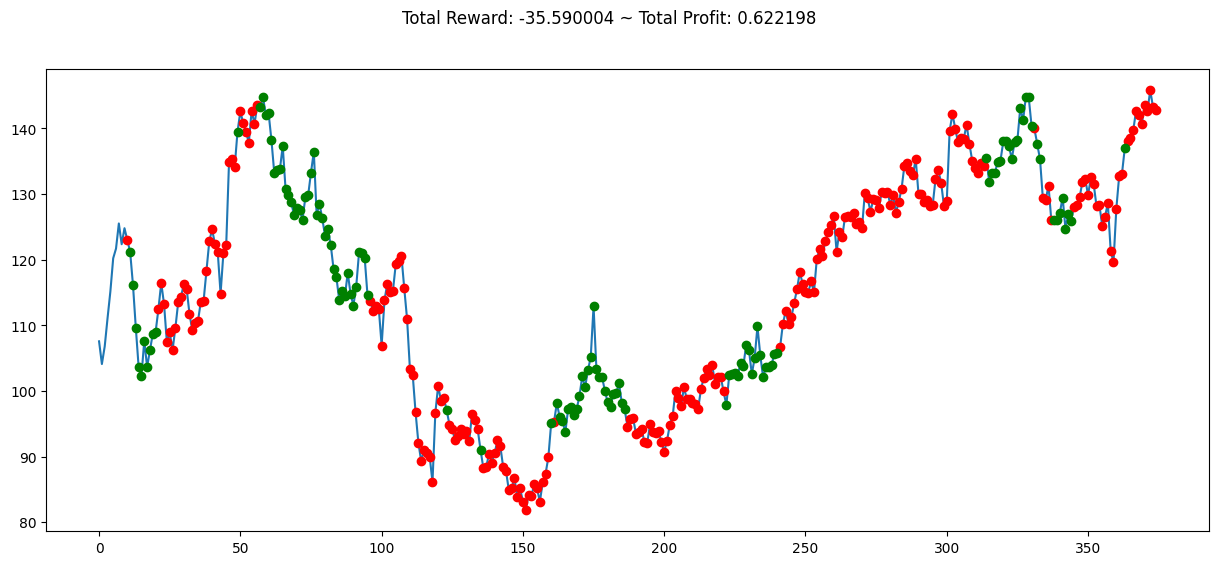

In [75]:
plt.figure(figsize=(15,6))
plt.cla()
env_amzn_ddqn.render_all()
plt.show()

In [76]:
test_env_amzn_ddqn = create_env('AMZN', 90, 0)
test_model(ddqn_agent_amzn, test_env_amzn_ddqn, epsilon=0.01)

Total reward: -3.45001220703125, Steps: 89, Info: {'total_reward': -3.45001220703125, 'total_profit': 0.9628930407070814, 'position': <Positions.Short: 0>}


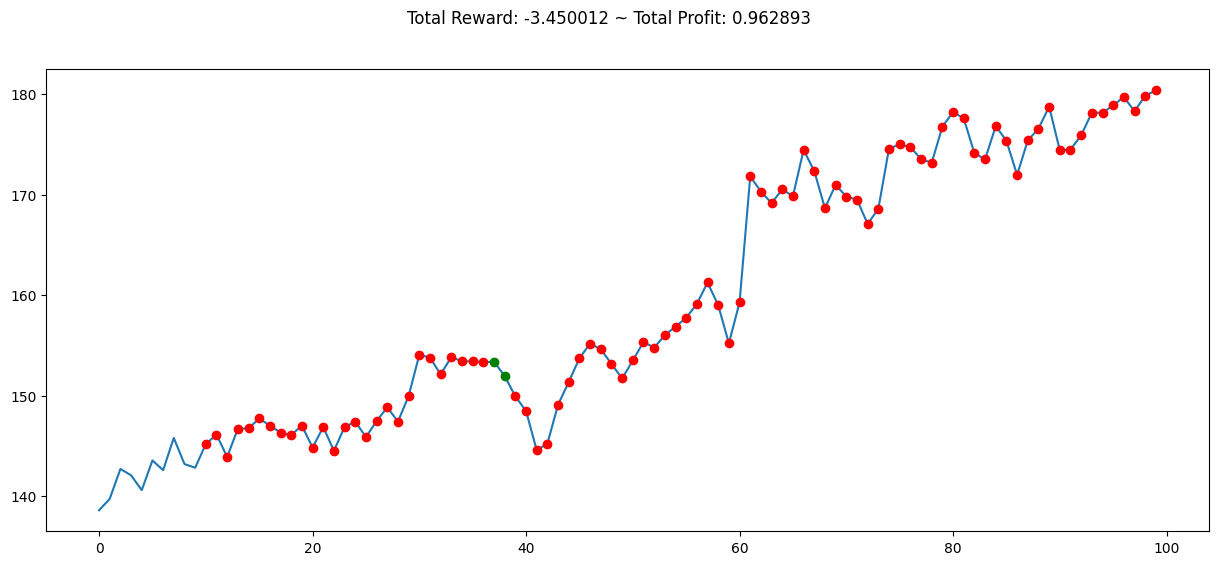

In [77]:
plt.figure(figsize=(15,6))
plt.cla()
test_env_amzn_ddqn.render_all()
plt.show()

### TSLA

In [78]:
env_tsla_ddqn = create_env('TSLA', 365, 90)

state_dim = env.observation_space.shape[0] * env.observation_space.shape[1]
action_dim = env.action_space.n  
learning_rate = 0.0075
hidden_dims = [64, 32]
memory_size = 10000
batch_size = 32
gamma = 0.6  
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 0.9

ddqn_agent_tsla = DDQN(state_dim, action_dim, learning_rate, hidden_dims=hidden_dims,
                memory_size=memory_size, batch_size=batch_size, gamma=gamma,
                epsilon_start=epsilon_start, epsilon_end=epsilon_end, epsilon_decay=epsilon_decay)

TARGET_UPDATE = 10
num_episodes = 1000

for episode in range(num_episodes):
    state = env_tsla_ddqn.reset()[0]
    steps = 0
    
    while True:
        action = ddqn_agent_tsla.select_action(state)  # Use DQN agent to select action
        next_state, reward, terminated, truncated, info = env_tsla_ddqn.step(action)
        done = terminated or truncated

        # Store the transition in memory
        ddqn_agent_tsla.memory.append((state, action, reward, next_state, done))

        # Move to the next state
        state = next_state

        # Perform one step of the optimization
        ddqn_agent_tsla.optimize_model()

        steps += 1

        if done:
            #print(f"Episode: {episode + 1}, Info: {info}")
            break
        
    # Update the target network, copying all weights and biases in DQN
    if episode % TARGET_UPDATE == 0:
        ddqn_agent_tsla.update_target_network()

   
    ddqn_agent_tsla.decay_epsilon()

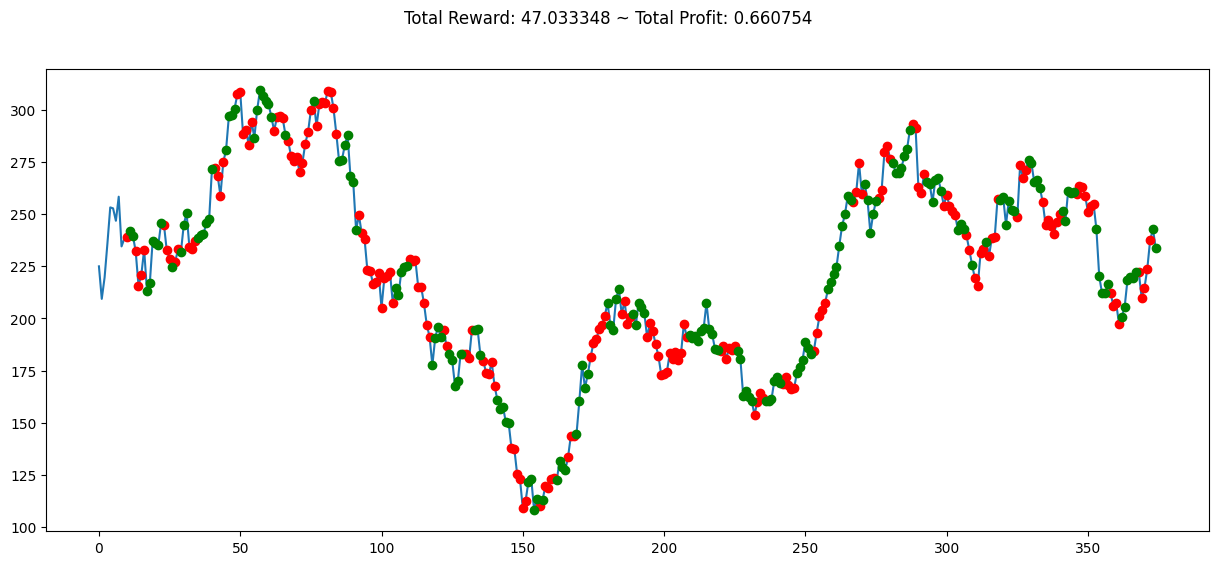

In [79]:
plt.figure(figsize=(15,6))
plt.cla()
env_tsla_ddqn.render_all()
plt.show()

In [80]:
test_env_tsla_ddqn = create_env('TSLA', 90, 0)
test_model(ddqn_agent_tsla, test_env_tsla_ddqn, epsilon=0.01)

Total reward: 0, Steps: 89, Info: {'total_reward': 0.0, 'total_profit': 0.7349827181686189, 'position': <Positions.Long: 1>}


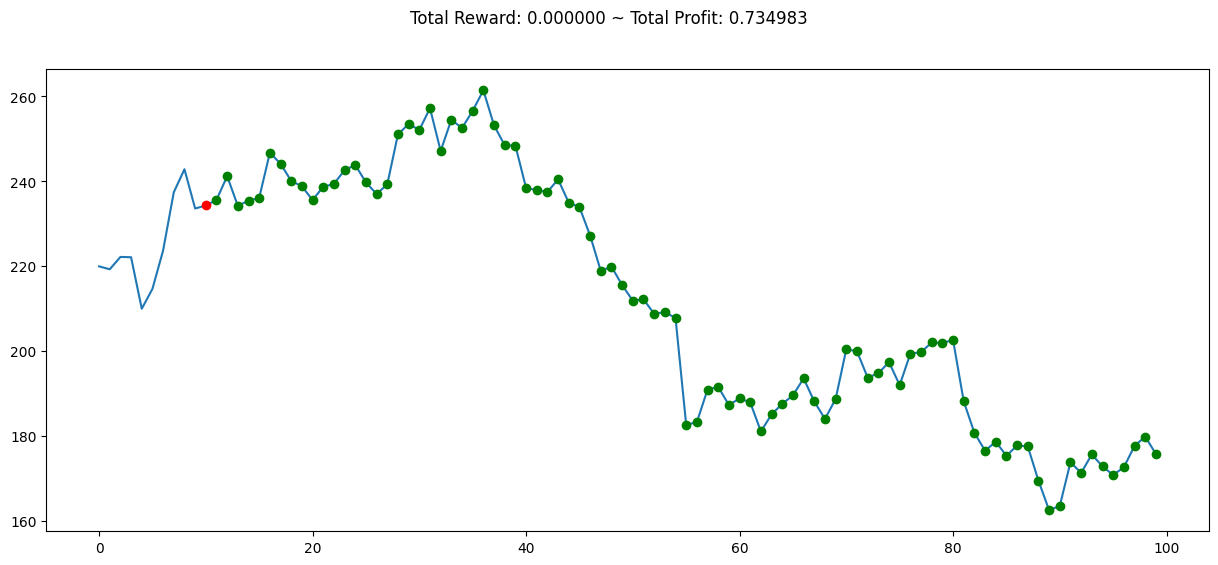

In [81]:
plt.figure(figsize=(15,6))
plt.cla()
test_env_tsla_ddqn.render_all()
plt.show()

## Dueling DDQN Training

### AAPL

In [62]:
env = create_env('AAPL', 365, 90)

state_dim = env.observation_space.shape[0] * env.observation_space.shape[1]
action_dim = env.action_space.n  
learning_rate = 0.005
hidden_dims = [64, 64]
memory_size = 10000
batch_size = 32
gamma = 0.8
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 0.9

duelingddqn_agent = DuelingDDQN(state_dim, action_dim, learning_rate, hidden_dims=hidden_dims,
                memory_size=memory_size, batch_size=batch_size, gamma=gamma,
                epsilon_start=epsilon_start, epsilon_end=epsilon_end, epsilon_decay=epsilon_decay)

TARGET_UPDATE = 10
num_episodes = 1000

for episode in range(num_episodes):
    state = env.reset()[0]
    steps = 0
    
    while True:
        action = duelingddqn_agent.select_action(state)  # Use DQN agent to select action
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        # Store the transition in memory
        duelingddqn_agent.memory.append((state, action, reward, next_state, done))

        # Move to the next state
        state = next_state

        # Perform one step of the optimization
        duelingddqn_agent.optimize_model()

        steps += 1

        if done:
            #print(f"Episode: {episode + 1}, Info: {info}")
            break
        
    # Update the target network, copying all weights and biases in DQN
    if episode % TARGET_UPDATE == 0:
        duelingddqn_agent.update_target_network()

    duelingddqn_agent.decay_epsilon()

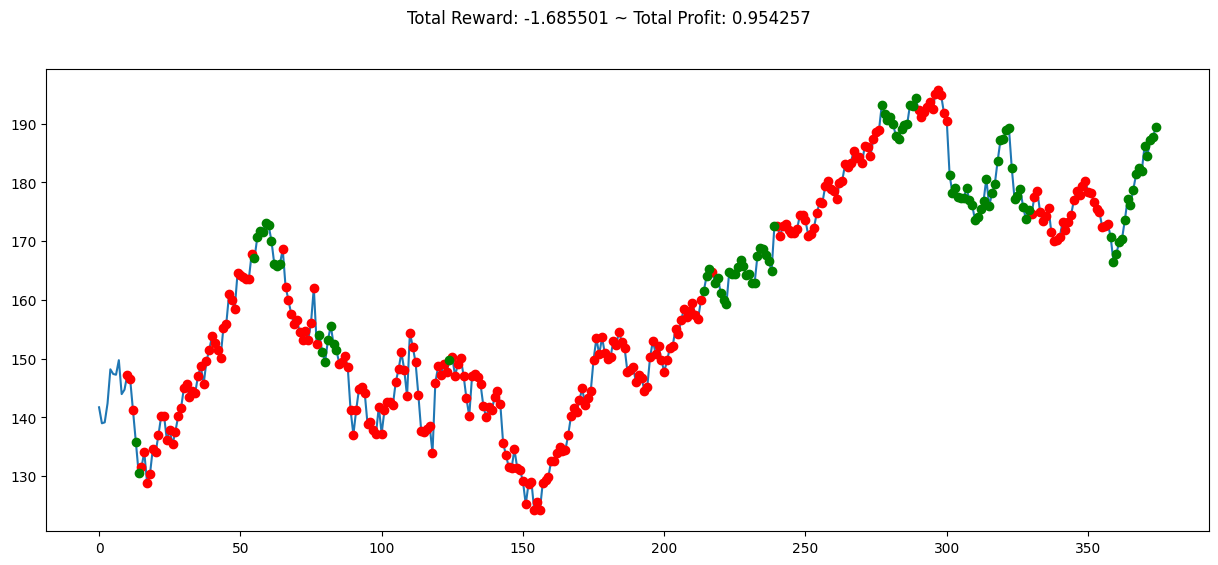

In [63]:
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

In [64]:
test_env = create_env('AAPL', 90, 0)
test_model(duelingddqn_agent, test_env, epsilon=0.01)

Total reward: 0, Steps: 89, Info: {'total_reward': 0.0, 'total_profit': 0.8834260531525447, 'position': <Positions.Long: 1>}


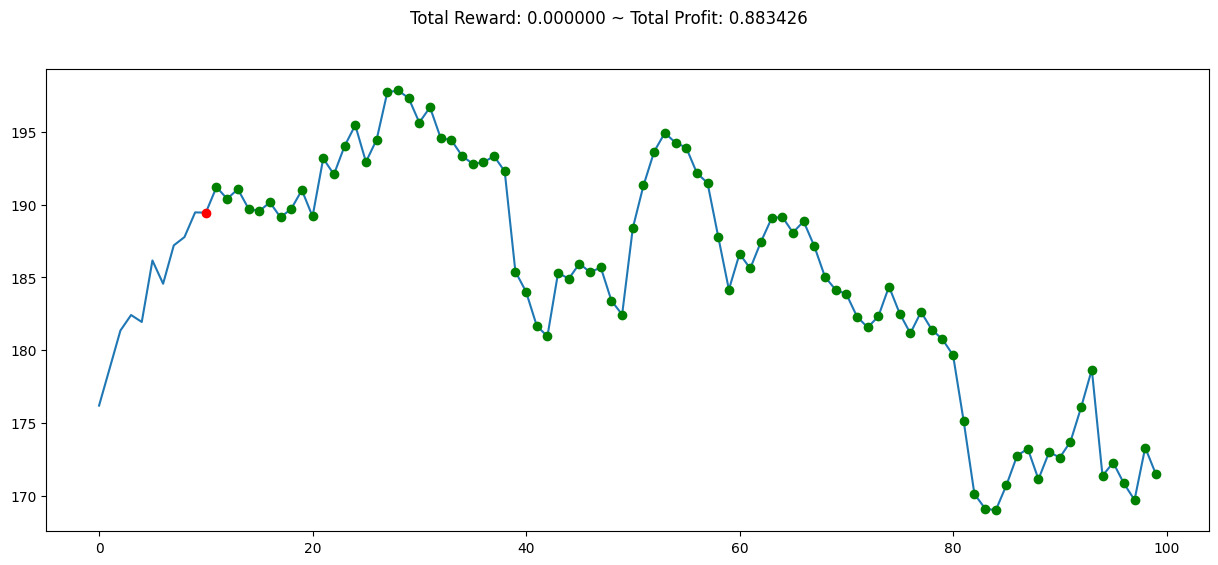

In [65]:
plt.figure(figsize=(15,6))
plt.cla()
test_env.render_all()
plt.show()

### AMZN

In [82]:
env_amzn_duelingddqn = create_env('AMZN', 365, 90)

state_dim = env.observation_space.shape[0] * env.observation_space.shape[1]
action_dim = env.action_space.n  
learning_rate = 0.001
hidden_dims = [64, 32]
memory_size = 10000
batch_size = 12
gamma = 0.8
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 0.9

duelingddqn_agent_amzn = DuelingDDQN(state_dim, action_dim, learning_rate, hidden_dims=hidden_dims,
                memory_size=memory_size, batch_size=batch_size, gamma=gamma,
                epsilon_start=epsilon_start, epsilon_end=epsilon_end, epsilon_decay=epsilon_decay)

TARGET_UPDATE = 10
num_episodes = 1000

for episode in range(num_episodes):
    state = env_amzn_duelingddqn.reset()[0]
    steps = 0
    
    while True:
        action = duelingddqn_agent_amzn.select_action(state)  # Use DQN agent to select action
        next_state, reward, terminated, truncated, info = env_amzn_duelingddqn.step(action)
        done = terminated or truncated

        # Store the transition in memory
        duelingddqn_agent_amzn.memory.append((state, action, reward, next_state, done))

        # Move to the next state
        state = next_state

        # Perform one step of the optimization
        duelingddqn_agent_amzn.optimize_model()

        steps += 1

        if done:
            #print(f"Episode: {episode + 1}, Info: {info}")
            break
        
    # Update the target network, copying all weights and biases in DQN
    if episode % TARGET_UPDATE == 0:
        duelingddqn_agent_amzn.update_target_network()

    duelingddqn_agent_amzn.decay_epsilon()

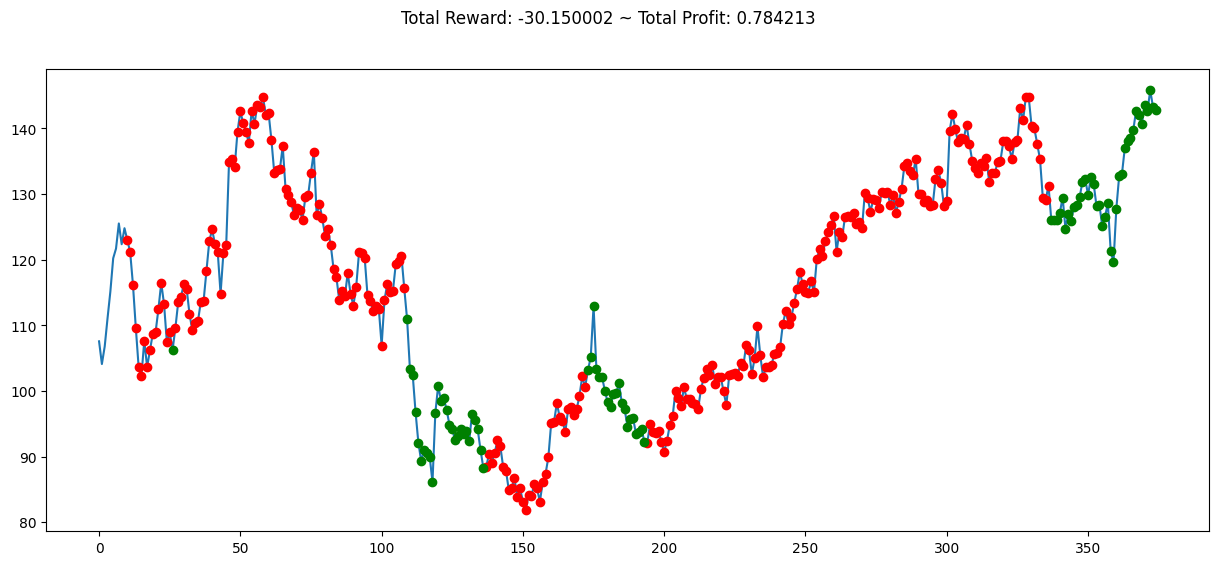

In [83]:
plt.figure(figsize=(15,6))
plt.cla()
env_amzn_duelingddqn.render_all()
plt.show()

In [84]:
test_env_amzn_duelingddqn = create_env('AMZN', 90, 0)
test_model(duelingddqn_agent_amzn, test_env_amzn_duelingddqn, epsilon=0.01)

Total reward: 0, Steps: 89, Info: {'total_reward': 0.0, 'total_profit': 1.215926352375789, 'position': <Positions.Long: 1>}


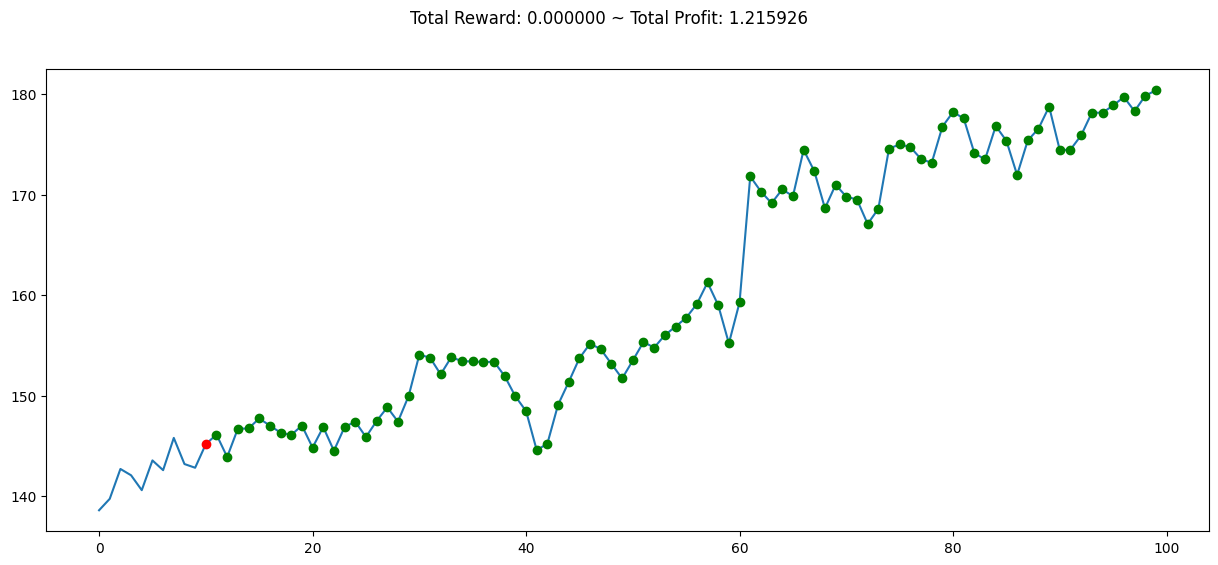

In [85]:
plt.figure(figsize=(15,6))
plt.cla()
test_env_amzn_duelingddqn.render_all()
plt.show()

### TSLA

In [86]:
env_tsla_duelingddqn = create_env('TSLA', 365, 90)

state_dim = env.observation_space.shape[0] * env.observation_space.shape[1]
action_dim = env.action_space.n  
learning_rate = 0.0075
hidden_dims = [64, 32]
memory_size = 10000
batch_size = 16
gamma = 0.8 
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 0.9

duelingddqn_agent_tsla = DuelingDDQN(state_dim, action_dim, learning_rate, hidden_dims=hidden_dims,
                memory_size=memory_size, batch_size=batch_size, gamma=gamma,
                epsilon_start=epsilon_start, epsilon_end=epsilon_end, epsilon_decay=epsilon_decay)

TARGET_UPDATE = 10
num_episodes = 1000

for episode in range(num_episodes):
    state = env_tsla_duelingddqn.reset()[0]
    steps = 0
    
    while True:
        action = duelingddqn_agent_tsla.select_action(state)  # Use DQN agent to select action
        next_state, reward, terminated, truncated, info = env_tsla_duelingddqn.step(action)
        done = terminated or truncated

        # Store the transition in memory
        duelingddqn_agent_tsla.memory.append((state, action, reward, next_state, done))

        # Move to the next state
        state = next_state

        # Perform one step of the optimization
        duelingddqn_agent_tsla.optimize_model()

        steps += 1

        if done:
            #print(f"Episode: {episode + 1}, Info: {info}")
            break
        
    # Update the target network, copying all weights and biases in DQN
    if episode % TARGET_UPDATE == 0:
        duelingddqn_agent_tsla.update_target_network()

    
    duelingddqn_agent_tsla.decay_epsilon()

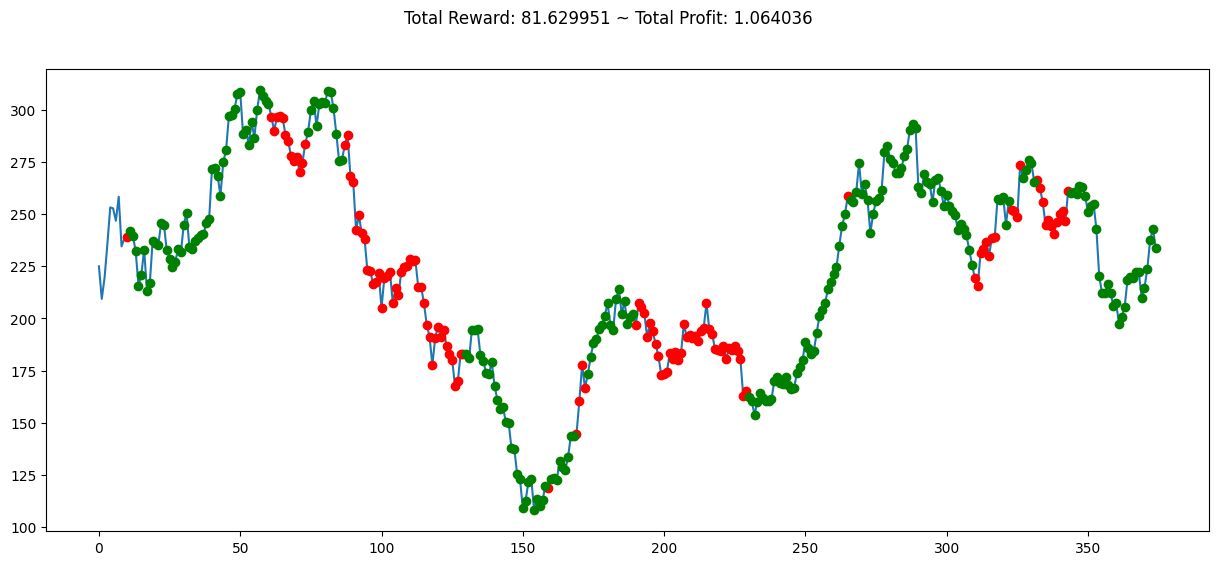

In [87]:
plt.figure(figsize=(15,6))
plt.cla()
env_tsla_duelingddqn.render_all()
plt.show()

In [102]:
test_env_tsla_duelingddqn = create_env('TSLA', 90, 0)
test_model(duelingddqn_agent_tsla, test_env_tsla_duelingddqn, epsilon=0.01)

Total reward: 0, Steps: 89, Info: {'total_reward': 0.0, 'total_profit': 0.7349827181686189, 'position': <Positions.Long: 1>}


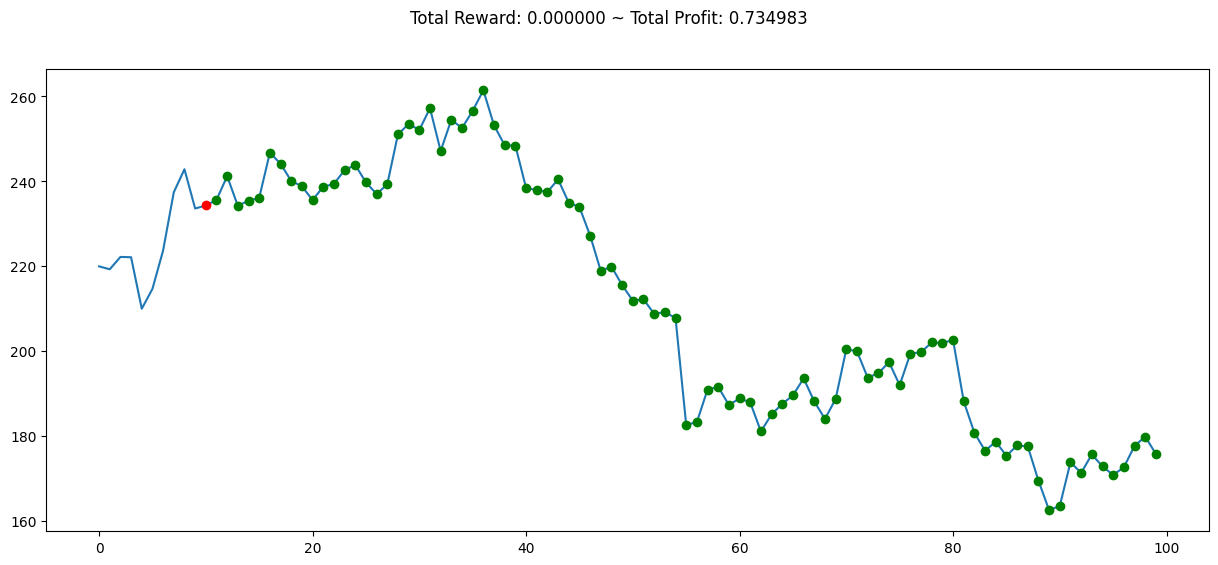

In [89]:
plt.figure(figsize=(15,6))
plt.cla()
test_env_tsla_duelingddqn.render_all()
plt.show()